***Capstone Project - The Battle of the Neighborhoods***
***FINAL REPORT***


***Applied Data Science Capstone by IBM/Coursera***

***Introduction: Business Problem***
This project aims to select the safest borough in London based on the total crimes, explore the neighborhoods of that borough to find the 10 most common venues in each neighborhood and finally cluster the neighborhoods using k-mean clustering.

This report will be targeted to people who are looking to relocate to London. Inorder to finalise a neighborhood to hunt for an apartment, safety is considered as a top concern when moving to a new place. If you don’t feel safe in your own home, you’re not going to be able to enjoy living there. The crime statistics will provide an insight into this issue.

We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected

Data 
Based on definition of our problem, factors that will influence our decision are:

The total number of crimes commited in each of the borough during the last year.
The most common venues in each of the neighborhood in the safest borough selected.

London Crime Data
About this file

lsoa_code: code for Lower Super Output Area in Greater London.
borough: Common name for London borough.
major_category: High level categorization of crime
minor_category: Low level categorization of crime within major category.
value: monthly reported count of categorical crime in given borough
year: Year of reported counts, 2008-2016
month: Month of reported counts, 1-12
Data set URL: https://www.kaggle.com/jboysen/london-crime

*Import necessary libraries*

In [17]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

!conda install -c conda-forge geocoder --yes
import geocoder

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed
Libraries imported.


In [24]:
CLIENT_ID = 'BQZSYSMJTC3M4RJYSXEIYFIWPM0ROCCZWDQCBRFPIWHTNXLA' # your Foursquare ID
CLIENT_SECRET = 'PS3SNU52W1PZIRLIKQ2LMSJZYIXCRSRMJ1S3YPAY1YBVLRMG ' # your Foursquare Secret
VERSION = '20191028'
LIMIT = 150

address = "Mccallum Street, Singapore"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude 
longitude =location.longitude 

Place='Mccallum Street,Singapore: {},{}'.format(latitude,longitude)
print(Place)

Mccallum Street,Singapore: 1.2795465,103.8476049


In [27]:
neighborhood_latitude=1.2792655
neighborhood_longitude=103.8480938

In [28]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=BQZSYSMJTC3M4RJYSXEIYFIWPM0ROCCZWDQCBRFPIWHTNXLA&client_secret=PS3SNU52W1PZIRLIKQ2LMSJZYIXCRSRMJ1S3YPAY1YBVLRMG &v=20191028&ll=1.2792655,103.8480938&radius=500&limit=100'

In [29]:
# results display is hidden for report simplification 
results = requests.get(url).json()
#results

function that extracts the category of the venue - borrow from the Foursquare lab

In [30]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [31]:
venues = results['response']['groups'][0]['items']
SGnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues =SGnearby_venues.loc[:, filtered_columns]
# filter the category for each row
SGnearby_venues['venue.categories'] = SGnearby_venues.apply(get_category_type, axis=1)
# clean columns
SGnearby_venues.columns = [col.split(".")[-1] for col in SGnearby_venues.columns]

SGnearby_venues.shape

C:\Users\srilatha\Anaconda3\Anaconda Navigator1\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


(100, 4)

In [32]:
# Venues near current Singapore residence place
SGnearby_venues.head(10)

,name,categories,lat,lng
0,Napoleon Food & Wine Bar,Wine Bar,1.279925,103.847333
1,Native,Cocktail Bar,1.280135,103.846844
2,Park Bench Deli,Deli / Bodega,1.279872,103.847287
3,Freehouse,Beer Garden,1.281254,103.848513
4,Pepper Bowl,Asian Restaurant,1.279371,103.846710
5,Meat Smith,Southern / Soul Food Restaurant,1.280205,103.847410
6,Anglo Indian Cafe & Bar,Indian Restaurant,1.279084,103.850127
7,Mellower Coffee,Café,1.277814,103.848188
8,PS.Cafe,Café,1.280468,103.846264
9,Lau Pa Sat Satay Street,Street Food Gathering,1.280261,103.850235


***Map of Singapore residence place with venues in Neighborhood - for reference***

In [33]:
latitude=1.2792655
longitude=103.8480938
# create map of Singapore place  using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=18)
# add markers to map
for lat, lng, label in zip(SGnearby_venues['lat'], SGnearby_venues['lng'], SGnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_color='#0f0f0f',
        fill_opacity=0.6,
    ).add_to(map_sg)  
    
map_sg

***MANHATTAN NEIGHBORHOODS - DATA AND MAPPING
Cluster neighborhood data was produced with Foursquare during course lab work. A csv file was produced containing the neighborhoods around the 40 Boroughs. Now, the csv file is just read for convenience and consolidation of report***

In [34]:
# Read csv file with clustered neighborhoods with geodata
manhattan_data  = pd.read_csv('mh_neigh_data.csv') 
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,2
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,4
3,Manhattan,Inwood,40.867684,-73.921210,3
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0


In [35]:
manhattan_data.tail()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
35,Manhattan,Turtle Bay,40.752042,-73.967708,3
36,Manhattan,Tudor City,40.746917,-73.971219,3
37,Manhattan,Stuyvesant Town,40.731000,-73.974052,4
38,Manhattan,Flatiron,40.739673,-73.990947,3
39,Manhattan,Hudson Yards,40.756658,-74.000111,2


***Manhattan Borough neighborhoods - data with top 10 clustered venues***


In [36]:
manhattan_merged = pd.read_csv('manhattan_merged.csv')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Sandwich Place,Park,Gym,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Mexican Restaurant,Coffee Shop,Café,Deli / Bodega,Pizza Place,Liquor Store,Indian Restaurant,Sushi Restaurant,Sandwich Place,Yoga Studio


***Map of Manhattan neighborhoods with top 10 clustered venues
popus allow to identify each neighborhood and the cluster of venues around it in order to proceed to examine in more detail in the next cell***

In [44]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the manhattan

# add markers to the map
folium.features.CircleMarker(
    [latitude, longitude],
    radius=20,
    color='red',
    popup='Manhattan',
    fill = True,
    fill_color = 'blue',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers for rental places to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(map_clusters)

# display map
map_clusters

In [45]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


***Map of Manhattan places for rent***
Several Manhattan real estate webs were webscrapped to collect rental data, as mentioned in section 2.0 . The resut was summarized in a csv file for direct reading, in order to consolidate the proces.
The initial data for 144 apartment did not have the latitude and longitude data (NaN) but the information was established in the following cell using an algorythm and Nominatim.

In [46]:
# csv files with rental places with basic data but still wihtout geodata ( latitude and longitude)
# pd.read_csv(' le.csv', header=None, nrows=5)
mh_rent=pd.read_csv('MH_flats_price.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,NaN,NaN
1,East 97th Street,Upper East Side,3.57,3,2100,7500,NaN,NaN
2,West 105th Street,Upper West Side,1.89,4,2800,5300,NaN,NaN
3,CARMINE ST.,West Village,3.03,2,1650,5000,NaN,NaN
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,NaN,NaN


In [47]:
mh_rent.tail()


,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3,1700,8750,NaN,NaN
140,50 Murray Street,No fee rental in Tribeca,7.11,2,1223,8700,NaN,NaN
141,300 East 56th Street,No fee rental in Midtown East,3.87,3,2100,8118,NaN,NaN
142,1930 Broadway,No fee rental in Central Park West,5.06,2,1600,8095,NaN,NaN
143,33 West 9th Street,Rental in Greenwich Village,6.67,2,1500,10000,NaN,NaN


**Obtain geodata ( lat,long) for each rental place in Manhattan with Nominatim**
Data was stored in a csv file for simplifaction report purposes and saving code processing time in future.
This coding section was 'markedown' for the report because its execution takes few minutes . Terefore, the csv saved will be be just read directly in the following cell.
for n in range(len(mh_rent)):
address= mh_rent['Address'][n] address=(mh_rent['Address'][n]+ ' , '+' Manhattan NY ') geolocator = Nominatim() location = geolocator.geocode(address) latitude = location.latitude longitude = location.longitude mh_rent['Lat'][n]=latitude mh_rent['Long'][n]=longitude

#print(n,latitude,longitude)
time.sleep(2)

print('Geodata completed')

*save dataframe to csv file*
mh_rent.to_csv('MH_rent_latlong.csv',index=False) mh_rent.shape

In [48]:
mh_rent=pd.read_csv('MH_rent_latlong.csv')
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,40.744118,-73.995299


In [49]:
mh_rent.tail()


,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
139,200 East 72nd Street,Rental in Lenox Hill,5.15,3,1700,8750,40.769465,-73.960339
140,50 Murray Street,No fee rental in Tribeca,7.11,2,1223,8700,40.714051,-74.009608
141,300 East 56th Street,No fee rental in Midtown East,3.87,3,2100,8118,40.758216,-73.965190
142,1930 Broadway,No fee rental in Central Park West,5.06,2,1600,8095,40.772474,-73.981901
143,33 West 9th Street,Rental in Greenwich Village,6.67,2,1500,10000,40.733691,-73.997323


***Manhattan apartment rent price statistics***

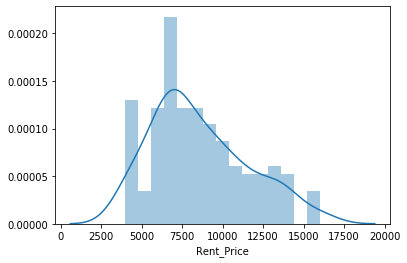

In [50]:
import seaborn as sns
sns.distplot(mh_rent['Rent_Price'],bins=15)

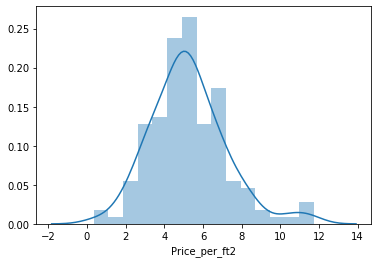

In [51]:
import seaborn as sns
sns.distplot(mh_rent['Price_per_ft2'],bins=15)

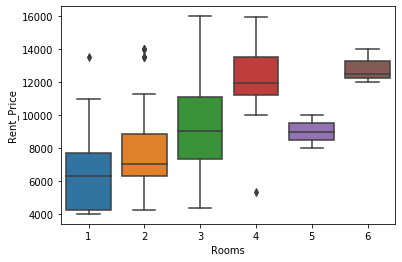

In [52]:
sns.boxplot(x='Rooms', y= 'Rent_Price', data=mh_rent)

***Map of Manhattan apartments for rent***

In [53]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ ',  '+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    

map_manhattan_rent

**Map of Manhattan showing the places for rent and the cluster of venues
Now, one can point to a rental place for price and address location information while knowing the cluster venues around it.
This is an insightful way to explore rental possibilites**

In [55]:
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
5,Manhattanville,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife
10,Lenox Hill,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Café,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store
27,Gramercy,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop
29,Financial District,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop


Mapping Manhattan Subway locations
Manhattan subway metro locations ( address) was obtained from webscrapping sites such as Wikipedia, Google and NY Metro Transit. For simplification, a csv file was produced from the 'numbers' (Apple excel ) so that the reading of this file is the starting point here.
The geodata will be obtain via Nominatim using the algorythm below.

In [56]:
# A csv file summarized the subway station and the addresses for next step to determine geodata
mh=pd.read_csv('NYC_subway_list.csv')
mh.head()

,sub_station,sub_address
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA"
1,57 Street Subway Station,"New York, NY 10106, USA"
2,Broad St,"New York, NY 10005, USA"
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA"
4,5 Av and 53 St,"New York, NY 10022, USA"


**Add colums labeled 'lat' and 'long' to be filled with geodata**


In [57]:
#  Add columns 'lat'  and 'long' to mh dataframe - with random temporary numbers to get started
sLength = len(mh['sub_station'])
lat = pd.Series(np.random.randn(sLength))
long=pd.Series(np.random.randn(sLength))
mh = mh.assign(lat=lat.values)
mh = mh.assign(long=long.values)

Algorythm to find latitude and longitud for each subway metro station and add them to dataframe
This coding has been 'Markdown' just to simplify the file report, and the csv file will be read in cell below.
for n in range(len(mh)): address= mh['sub_address'][n] geolocator = Nominatim() location = geolocator.geocode(address) latitude = location.latitude longitude = location.longitude mh['lat'][n]=latitude mh['long'][n]=longitude

#print(n,latitude,longitude)
time.sleep(2)

print('Geodata completed')

save dataframe to csv file
mh.to_csv('MH_subway.csv',index=False) mh.shape

Read csv file that produced the subway stations list with geodata

In [58]:
mh=pd.read_csv('MH_subway.csv')
print(mh.shape)
mh.head()

(76, 4)


,sub_station,sub_address,lat,long
0,Dyckman Street Subway Station,"170 Nagle Ave, New York, NY 10034, USA",40.861857,-73.924509
1,57 Street Subway Station,"New York, NY 10106, USA",40.764250,-73.954525
2,Broad St,"New York, NY 10005, USA",40.730862,-73.987156
3,175 Street Station,"807 W 177th St, New York, NY 10033, USA",40.847991,-73.939785
4,5 Av and 53 St,"New York, NY 10022, USA",40.764250,-73.954525


In [59]:
# removing duplicate rows and creating new set mhsub1
mhsub1=mh.drop_duplicates(subset=['lat','long'], keep="last").reset_index(drop=True)
mhsub1.shape

(22, 4)

In [60]:
mhsub1.tail()

,sub_station,sub_address,lat,long
17,190 Street Subway Station,"Bennett Ave, New York, NY 10040, USA",40.858113,-73.932983
18,59 St-Lexington Av Station,"E 60th St, New York, NY 10065, USA",40.762259,-73.966271
19,57 Street Station,"New York, NY 10019, United States",40.764250,-73.954525
20,14 Street / 8 Av,"New York, NY 10014, United States",40.730862,-73.987156
21,MTA New York City,"525 11th Ave, New York, NY 10018, USA",40.759809,-73.999282


**MAP of Manhattan showing the location of subway stations**


In [61]:
# map subway stations 
# create map of Manhattan using latitude and longitude values obtain previoulsy via Moninatim geolocator
latitude=40.7308619
longitude=-73.9871558

map_mhsub1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_mhsub1) 
map_mhsub1

***Map of Manhattan showing places for rent and the subway locations nearby
Now, we can visualize the desirable rental places and their nearest subway station. Popups display rental address and monthly rental price and the subway station name.
Notice that the icon in the top-right corner is a "ruler" that allows to measure the distance from a rental place to an specific subway station***

In [62]:
mh_rent.head()

,Address,Area,Price_per_ft2,Rooms,Area-ft2,Rent_Price,Lat,Long
0,West 105th Street,Upper West Side,2.94,5,3400,10000,40.799771,-73.966213
1,East 97th Street,Upper East Side,3.57,3,2100,7500,40.788585,-73.955277
2,West 105th Street,Upper West Side,1.89,4,2800,5300,40.799771,-73.966213
3,CARMINE ST.,West Village,3.03,2,1650,5000,40.730523,-74.001873
4,171 W 23RD ST.,Chelsea,3.45,2,1450,5000,40.744118,-73.995299


In [63]:
# create map of Manhattan using latitude and longitude values from Nominatim
latitude= 40.7308619
longitude= -73.9871558

map_manhattan_rent = folium.Map(location=[latitude, longitude], zoom_start=13.3)

# add markers to map
for lat, lng, label in zip(mh_rent['Lat'], mh_rent['Long'],'$ ' + mh_rent['Rent_Price'].astype(str)+ mh_rent['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_rent) 
    
    # add markers of subway locations to map
for lat, lng, label in zip(mhsub1['lat'], mhsub1['long'],  mhsub1['sub_station'].astype(str) ):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=6,
        radius=6,
        popup=label,
        color='red',
        fill_color='red',
        fill_opacity=2.5,
    ).add_to(map_manhattan_rent) 
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_manhattan_rent.add_child(MeasureControl())

# Measurement ruler icon tool to measure distances in map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_manhattan_rent)

map_manhattan_rent

***Problem Resolution - Select the apartment for rent
The above consolidate map was used to explore options.
After examining, I have chosen two locations that meet the requirements which will assess to make a choice.
Apartment 1: 305 East 63rd Street in the Sutton Place Neighborhood and near 'subway 59th Street' station, Cluster # 2 Monthly rent : 7500 Dollars

Apartment 2: 19 Dutch Street in the Financial District Neighborhood and near 'Fulton Street Subway' station, Cluster # 3 Monthly rent : 6935 Dollars***

***Venues for Apartment 1 - Cluster 2***

In [65]:
## kk is the cluster number to explore
kk = 2
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Yoga Studio,Steakhouse,Supplement Shop,Tennis Stadium,Shoe Store,Gym,Bank,Seafood Restaurant
1,Chinatown,Chinese Restaurant,Cocktail Bar,Dim Sum Restaurant,American Restaurant,Vietnamese Restaurant,Salon / Barbershop,Noodle House,Bakery,Bubble Tea Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Chinese Restaurant,Event Space,Liquor Store,Beer Bar,Gym / Fitness Center
9,Yorkville,Coffee Shop,Gym,Bar,Italian Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Deli / Bodega,Japanese Restaurant,Pub
14,Clinton,Theater,Italian Restaurant,Coffee Shop,American Restaurant,Gym / Fitness Center,Hotel,Wine Shop,Spa,Gym,Indie Theater
23,Soho,Clothing Store,Boutique,Women's Store,Shoe Store,Men's Store,Furniture / Home Store,Italian Restaurant,Mediterranean Restaurant,Art Gallery,Design Studio
26,Morningside Heights,Coffee Shop,American Restaurant,Park,Bookstore,Pizza Place,Sandwich Place,Burger Joint,Café,Deli / Bodega,Tennis Court
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Indian Restaurant,Dessert Shop,American Restaurant,Bakery,Juice Bar,Boutique,Sushi Restaurant
39,Hudson Yards,Coffee Shop,Italian Restaurant,Hotel,Theater,American Restaurant,Café,Gym / Fitness Center,Thai Restaurant,Restaurant,Gym


Venues for Apartment 2 - Cluster 3


In [66]:
## kk is the cluster number to explore
kk = 3
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == kk, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Inwood,Mexican Restaurant,Lounge,Pizza Place,Café,Wine Bar,Bakery,American Restaurant,Park,Frozen Yogurt Shop,Spanish Restaurant
5,Manhattanville,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Sushi Restaurant,Beer Garden,Coffee Shop,Falafel Restaurant,Bike Trail,Other Nightlife
10,Lenox Hill,Sushi Restaurant,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Pizza Place,Burger Joint,Deli / Bodega,Gym,Sporting Goods Shop,Thai Restaurant
12,Upper West Side,Italian Restaurant,Bar,Bakery,Vegetarian / Vegan Restaurant,Indian Restaurant,Coffee Shop,Cosmetics Shop,Wine Bar,Mexican Restaurant,Sushi Restaurant
16,Murray Hill,Sandwich Place,Hotel,Japanese Restaurant,Gym / Fitness Center,Coffee Shop,Salon / Barbershop,Burger Joint,French Restaurant,Bar,Italian Restaurant
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Nightclub,Theater,Art Gallery,Seafood Restaurant,American Restaurant,Hotel
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Clothing Store,Chinese Restaurant,Café,Indian Restaurant,Bakery,Seafood Restaurant,Electronics Store
27,Gramercy,Italian Restaurant,Restaurant,Thrift / Vintage Store,Cocktail Bar,Bagel Shop,Coffee Shop,Pizza Place,Mexican Restaurant,Grocery Store,Wine Shop
29,Financial District,Coffee Shop,Hotel,Gym,Wine Shop,Steakhouse,Bar,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Gift Shop,Bookstore,Grocery Store,Mexican Restaurant,Hotel,Sushi Restaurant,Coffee Shop


***Apartment Selection
Using the "one map" above, I was able to explore all possibilities since the popups provide the information needed for a good decision.
Apartment 1 rent cost is US7500 slightly above the US7000 budget. Apt 1 is located 400 meters from subway station at 59th Street and work place ( Park Ave and 53rd) is another 600 meters way. I can walk to work place and use subway for other places aroung. Venues for this apt are as of Cluster 2 and it is located in a fine district in the East side of Manhattan.
Apartment 2 rent cost is US6935, just under the US7000 budget. Apt 2 is located 60 meters from subway station at Fulton Street, but I will have to ride the subway daily to work , possibly 40-60 min ride. Venues for this apt are as of Cluster 3.¶
Based on current Singapore venues, I feel that Cluster 2 type of venues is a closer resemblance to my current place. That means that APARTMENT 1 is a better choice since the extra monthly rent is worth the conveniences it provides***